
**UPDATED version 8:**

New additions:
- Training and evaluation comparing *2 different categorical feature encoding methods* - label encoding VS one-hot encoding
- EDA on `energy_star_rating`, `cooling_degree_days`, `heating_degree_days`
- SHAP values of model trained on one-hot encoding

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/widsdatathon2022/train.csv
/kaggle/input/widsdatathon2022/test.csv
/kaggle/input/widsdatathon2022/sample_solution.csv


In [2]:
# SHAP is not optimized for matplotlib 3.5.1
!pip install matplotlib==3.4.3

     |████████████████████████████████| 10.3 MB 890 kB/s            
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
beatrix-jupyterlab 3.1.4 requires google-cloud-bigquery-storage, which is not installed.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.4.3 which is incompatible.


# Data
The WiDS Datathon 2022 focuses on a prediction task involving roughly 100k observations of building energy usage records collected over 7 years and a number of states within the United States. The dataset consists of building characteristics (e.g. floor area, facility type etc), weather data for the location of the building (e.g. annual average temperature, annual total precipitation etc) as well as the energy usage for the building and the given year, measured as Site Energy Usage Intensity (Site EUI). Each row in the data corresponds to the a single building observed in a given year. Your task is to predict the Site EUI for each row, given the characteristics of the building and the weather data for the location of the building.

### Covariates

- `id`: building id
- `Year_Factor`: anonymized year in which the weather and energy usage factors were observed
- `State_Factor`: anonymized state in which the building is located
- `building_class`: building classification
- `facility_type`: building usage type
- `floor_area`: floor area (in square feet) of the building
- `year_built`: year in which the building was constructed
- `energy_star_rating`: the energy star rating of the building
- `ELEVATION`: elevation of the building location
- `january_min_temp`: minimum temperature in January (in Fahrenheit) at the location of the building
- `january_avg_temp`: average temperature in January (in Fahrenheit) at the location of the building
- `january_max_temp`: maximum temperature in January (in Fahrenheit) at the location of the building
- `cooling_degree_days`: cooling degree day for a given day is the number of degrees where the daily average temperature exceeds 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.
- `heating_degree_days`: heating degree day for a given day is the number of degrees where the daily average temperature falls under 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.
- `precipitation_inches`: annual precipitation in inches at the location of the building
- `snowfall_inches`: annual snowfall in inches at the location of the building
- `snowdepth_inches`: annual snow depth in inches at the location of the building
- `avg_temp`: average temperature over a year at the location of the building
- `days_below_30F`: total number of days below 30 degrees Fahrenheit at the location of the building
- `days_below_20F`: total number of days below 20 degrees Fahrenheit at the location of the building
- `days_below_10F`: total number of days below 10 degrees Fahrenheit at the location of the building
- `days_below_0F`: total number of days below 0 degrees Fahrenheit at the location of the building
- `days_above_80F`: total number of days above 80 degrees Fahrenheit at the location of the building
- `days_above_90F`: total number of days above 90 degrees Fahrenheit at the location of the building
- `days_above_100F`: total number of days above 100 degrees Fahrenheit at the location of the building
- `days_above_110F`: total number of days above 110 degrees Fahrenheit at the location of the building
- `direction_max_wind_speed`: wind direction for maximum wind speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).
- `direction_peak_wind_speed`: wind direction for peak wind gust speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).
- `max_wind_speed`: maximum wind speed at the location of the building
- `days_with_fog`: number of days with fog at the location of the building

### Target

- `site_eui`: Site Energy Usage Intensity is the amount of heat and electricity consumed by a building as reflected in utility bills

We first take a look at the training data below.

In [3]:
df_train = pd.read_csv("/kaggle/input/widsdatathon2022/train.csv")
df_train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                75757 non-null  int64  
 1   State_Factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   ELEVATION                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

From above, we can see that there are 75757 entries, and there exist null values in `year_built`, `energy_star_rating`, `direction_max_wind_speed`, `direction_peak_wind_speed`, `max_wind_speed`, and `days_with_fog`. In fact, there are quite a large number of rows containing null columns, so dropping rows with null values may not seem like a good strategy.

In [5]:
df_test = pd.read_csv("/kaggle/input/widsdatathon2022/test.csv")
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9705 entries, 0 to 9704
Data columns (total 63 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                9705 non-null   int64  
 1   State_Factor               9705 non-null   object 
 2   building_class             9705 non-null   object 
 3   facility_type              9705 non-null   object 
 4   floor_area                 9705 non-null   float64
 5   year_built                 9613 non-null   float64
 6   energy_star_rating         7451 non-null   float64
 7   ELEVATION                  9705 non-null   float64
 8   january_min_temp           9705 non-null   int64  
 9   january_avg_temp           9705 non-null   float64
 10  january_max_temp           9705 non-null   int64  
 11  february_min_temp          9705 non-null   int64  
 12  february_avg_temp          9705 non-null   float64
 13  february_max_temp          9705 non-null   int64

# EDA

For EDA part, I took inspiration and reference from [WiDS2022 EDA by @amdionascu](https://www.kaggle.com/amdionascu/wids2022-eda/notebook)

### Year_Factor

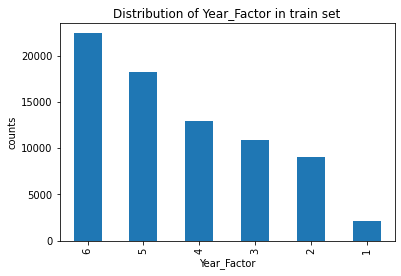

In [6]:
import matplotlib.pyplot as plt

pd.value_counts(df_train['Year_Factor']).plot.bar()
plt.title('Distribution of Year_Factor in train set')
plt.xlabel('Year_Factor')
plt.ylabel('counts')
plt.show()

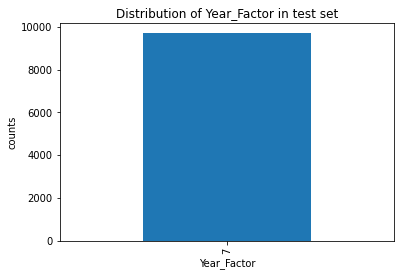

In [7]:
pd.value_counts(df_test['Year_Factor']).plot.bar()
plt.title('Distribution of Year_Factor in test set')
plt.xlabel('Year_Factor')
plt.ylabel('counts')
plt.show()

ℹ️ Train set and Test set have completely different Year_Factor distributions/range. Perhaps Year_Factor should not be used as input feature for model prediction.

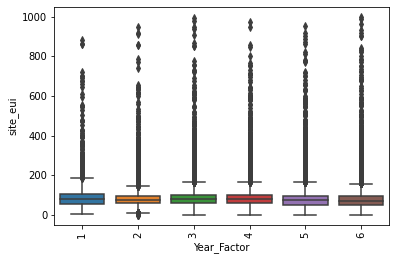

In [8]:
import seaborn as sns

ax = sns.boxplot(data=df_train, x='Year_Factor', y='site_eui')
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

ℹ️ The year does not seem to have an influence on the site_eui as it shows the same distribution over the years.

### State_Factor

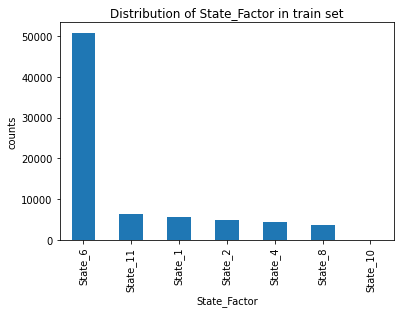

In [9]:
pd.value_counts(df_train['State_Factor']).plot.bar()
plt.title('Distribution of State_Factor in train set')
plt.xlabel('State_Factor')
plt.ylabel('counts')
plt.show()

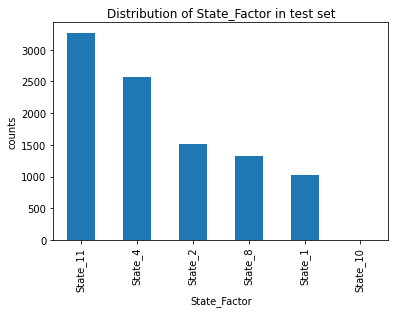

In [10]:
pd.value_counts(df_test['State_Factor']).plot.bar()
plt.title('Distribution of State_Factor in test set')
plt.xlabel('State_Factor')
plt.ylabel('counts')
plt.show()

ℹ️ The data mostly comes from State_6. However, none of the test data comes from State_6.

In [11]:
pd.value_counts(df_train['State_Factor'])

State_6     50840
State_11     6412
State_1      5618
State_2      4871
State_4      4300
State_8      3701
State_10       15
Name: State_Factor, dtype: int64

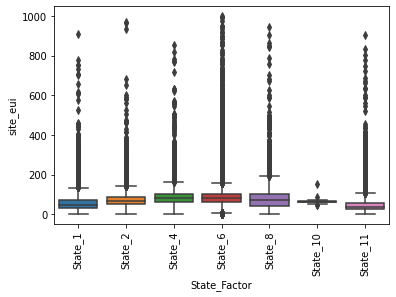

In [12]:
ax = sns.boxplot(data=df_train, x='State_Factor', y='site_eui')
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

### building_class

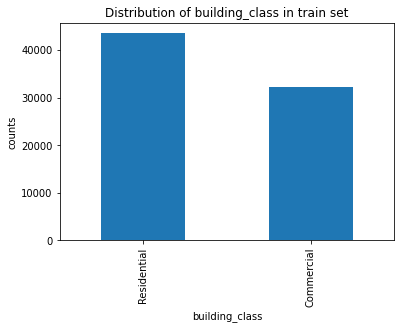

In [13]:
pd.value_counts(df_train['building_class']).plot.bar()
plt.title('Distribution of building_class in train set')
plt.xlabel('building_class')
plt.ylabel('counts')
plt.show()

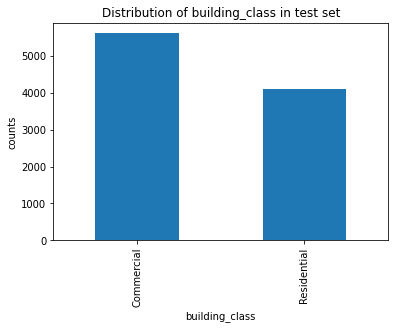

In [14]:
pd.value_counts(df_test['building_class']).plot.bar()
plt.title('Distribution of building_class in test set')
plt.xlabel('building_class')
plt.ylabel('counts')
plt.show()

ℹ️ There is similar distribution of building_class in train and test sets.

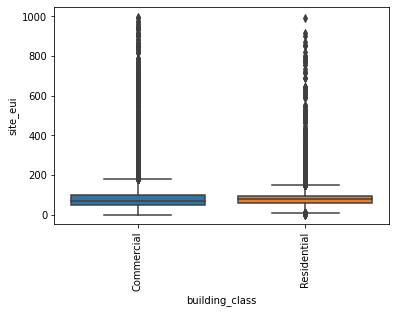

In [15]:
ax = sns.boxplot(data=df_train, x='building_class', y='site_eui')
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

### facility_type

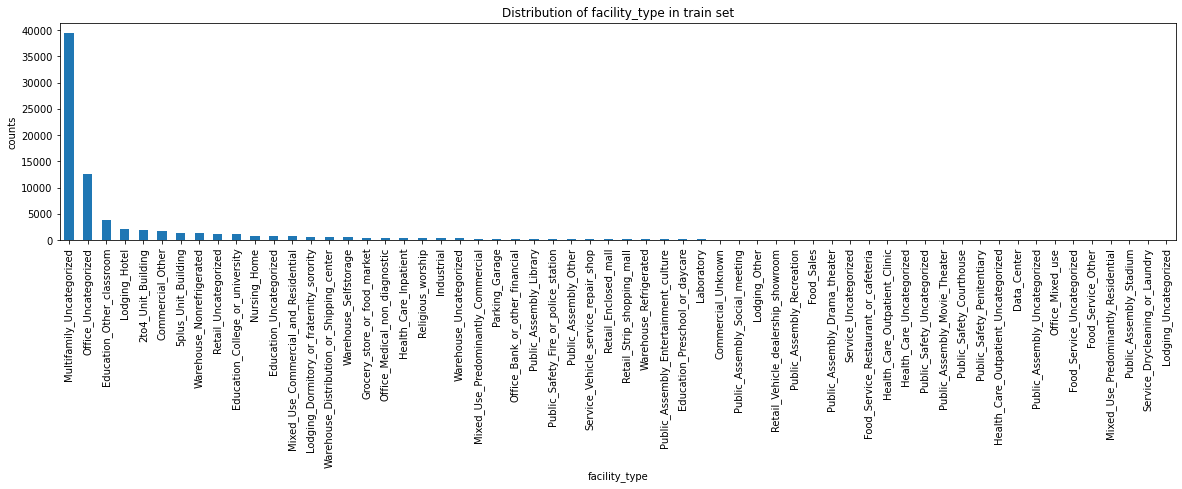

In [16]:
from matplotlib.pyplot import figure

figure(figsize=(20, 4))
pd.value_counts(df_train['facility_type']).plot.bar()
plt.title('Distribution of facility_type in train set')
plt.xlabel('facility_type')
plt.ylabel('counts')
plt.show()

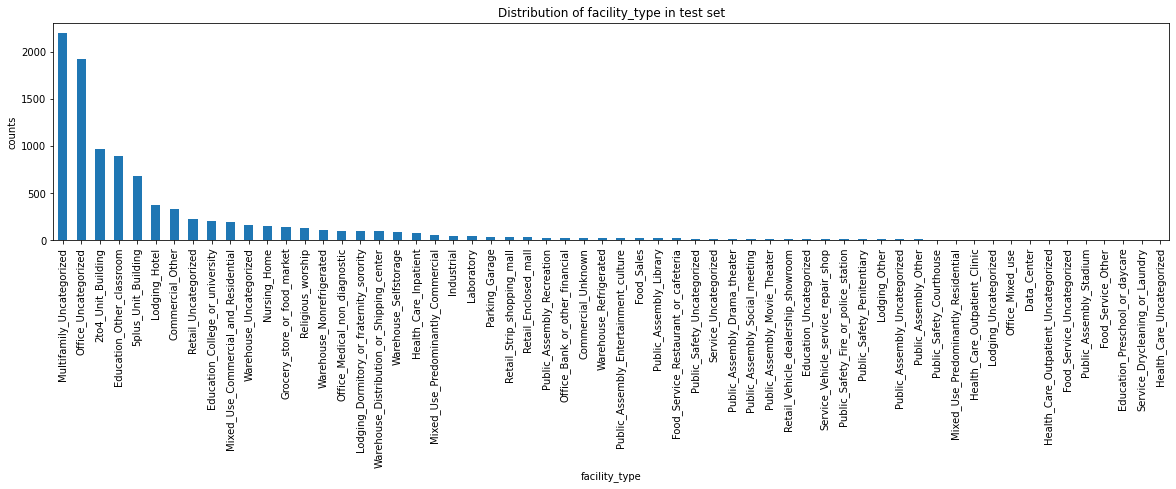

In [17]:
figure(figsize=(20, 4))
pd.value_counts(df_test['facility_type']).plot.bar()
plt.title('Distribution of facility_type in test set')
plt.xlabel('facility_type')
plt.ylabel('counts')
plt.show()

ℹ️ The top 2 facility_type in train and test sets are the same, namely `Multifamily_Uncategorized` and `Office_Uncategorized`. They contribute to the majority of the data.

In [18]:
print("List of facility_type:")
for i in df_train['facility_type'].unique():
    print(" ", i)

List of facility_type:
  Grocery_store_or_food_market
  Warehouse_Distribution_or_Shipping_center
  Retail_Enclosed_mall
  Education_Other_classroom
  Warehouse_Nonrefrigerated
  Warehouse_Selfstorage
  Office_Uncategorized
  Data_Center
  Commercial_Other
  Mixed_Use_Predominantly_Commercial
  Office_Medical_non_diagnostic
  Education_College_or_university
  Industrial
  Laboratory
  Public_Assembly_Entertainment_culture
  Retail_Vehicle_dealership_showroom
  Retail_Uncategorized
  Lodging_Hotel
  Retail_Strip_shopping_mall
  Education_Uncategorized
  Health_Care_Inpatient
  Public_Assembly_Drama_theater
  Public_Assembly_Social_meeting
  Religious_worship
  Mixed_Use_Commercial_and_Residential
  Office_Bank_or_other_financial
  Parking_Garage
  Commercial_Unknown
  Service_Vehicle_service_repair_shop
  Service_Drycleaning_or_Laundry
  Public_Assembly_Recreation
  Service_Uncategorized
  Warehouse_Refrigerated
  Food_Service_Uncategorized
  Health_Care_Uncategorized
  Food_Service_Oth

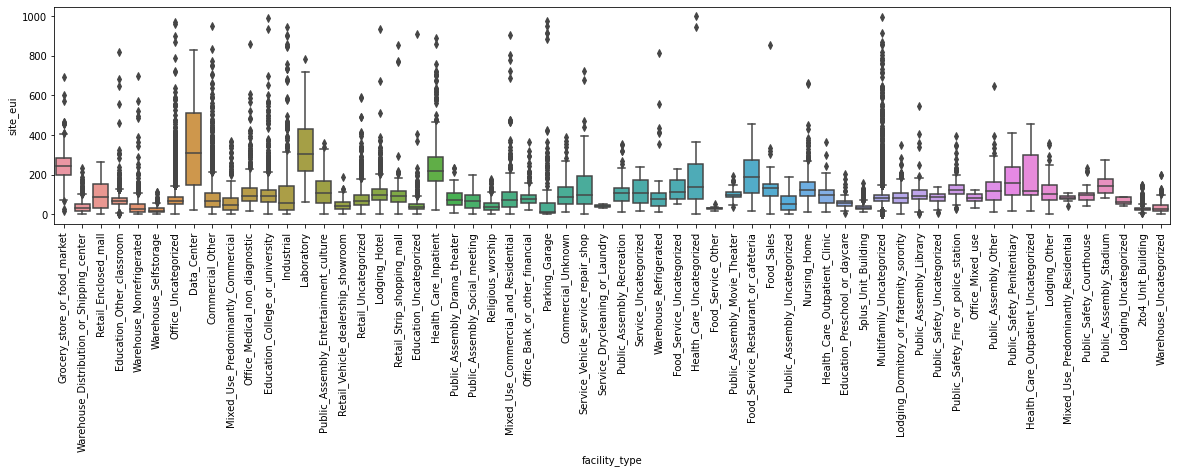

In [19]:
figure(figsize=(20, 4))
ax = sns.boxplot(data=df_train, x='facility_type', y='site_eui')
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

ℹ️ Some of the facility types show a greater site_eui than the other categories: 
* Grocery_store_or_food_market
* Data_Center
* Laboratory
* Health_Care - related

### id

In [20]:
print(df_train['id'].nunique())
print(df_test['id'].nunique())

75757
9705


ℹ️ All `id`s are unique. This column does not help with the prediction task.

### energy_star_rating

100.0    1946
1.0       985
79.0      782
84.0      781
89.0      781
         ... 
21.0      252
16.0      248
11.0      247
10.0      237
0.0         1
Name: energy_star_rating, Length: 101, dtype: int64


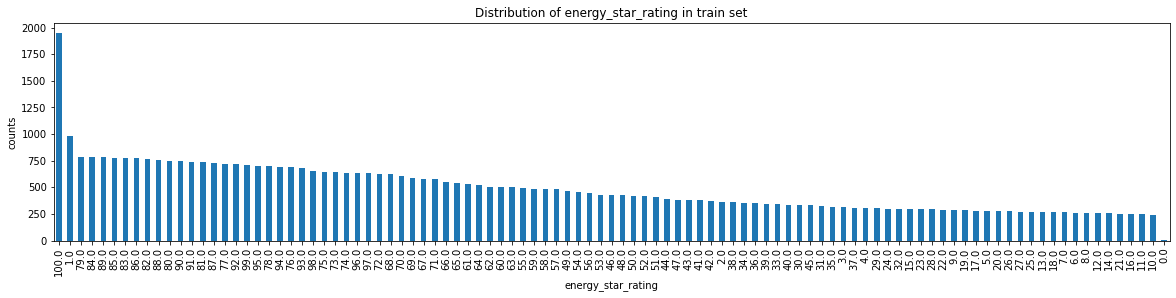

In [21]:
print(pd.value_counts(df_train['energy_star_rating']))
figure(figsize=(20, 4))
pd.value_counts(df_train['energy_star_rating']).plot.bar()
plt.title('Distribution of energy_star_rating in train set')
plt.xlabel('energy_star_rating')
plt.ylabel('counts')
plt.show()

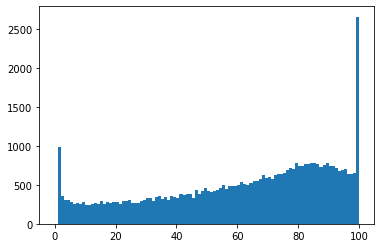

In [22]:
plt.hist(df_train['energy_star_rating'], bins=100)
plt.show()

ℹ️ The energy star rating of the buildings ranges from 0-100. With most buildings scoring 100, followed by 1.

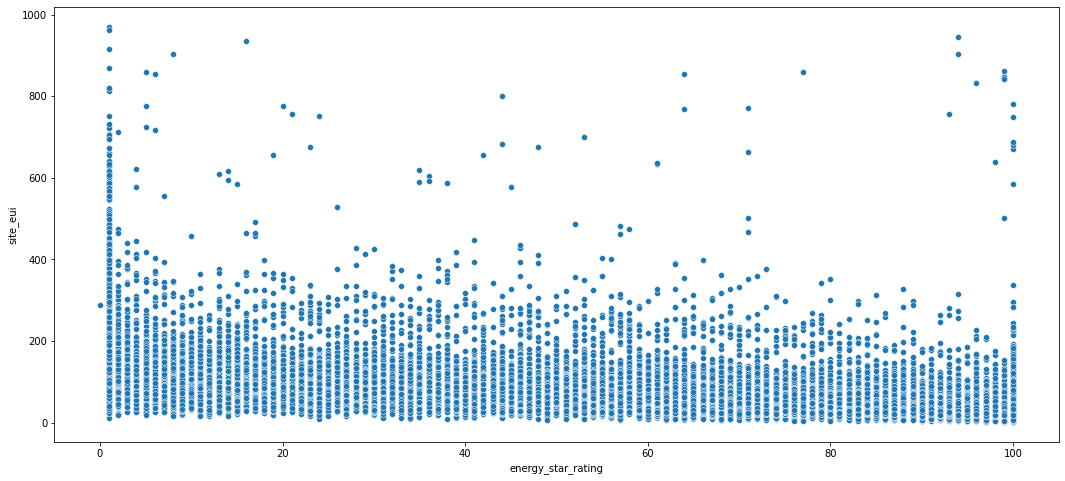

In [23]:
figure(figsize=(18, 8))
ax = sns.scatterplot(data=df_train, x='energy_star_rating', y='site_eui')

ℹ️ Despite having 100 energy star ratings, some buildings have high site eui.

### cooling_degree_days

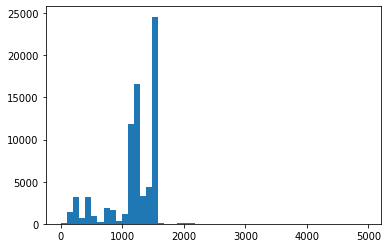

In [24]:
plt.hist(df_train['cooling_degree_days'], bins=50)
plt.show()

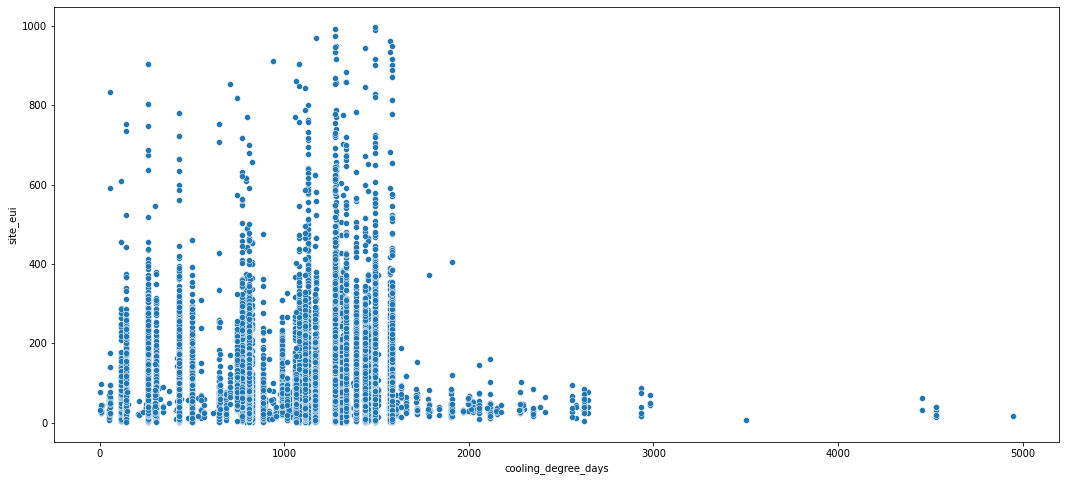

In [25]:
figure(figsize=(18, 8))
ax = sns.scatterplot(data=df_train, x='cooling_degree_days', y='site_eui')

ℹ️ `site_eui` increases with `cooling_degree_days` for cooling_degree_days less than ~1600

### heating_degree_days

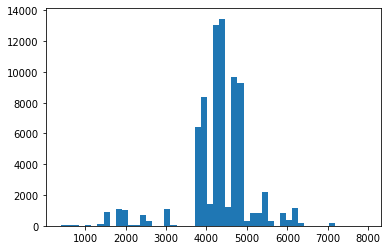

In [26]:
plt.hist(df_train['heating_degree_days'], bins=50)
plt.show()

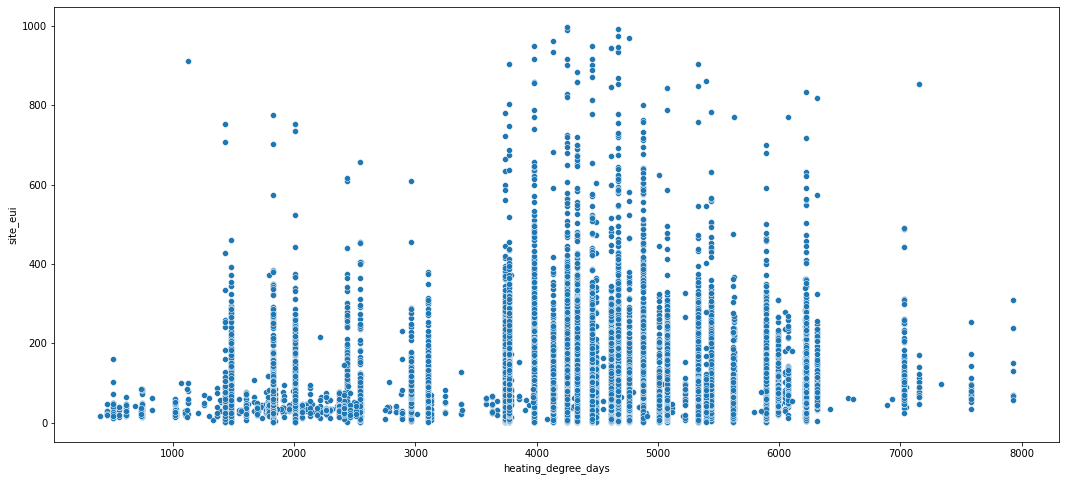

In [27]:
figure(figsize=(18, 8))
ax = sns.scatterplot(data=df_train, x='heating_degree_days', y='site_eui')

ℹ️ Interestingly, `site_eui` vs `heating_degree_days` looks like a skewed normal distribution.

## Data Preprocessing
### Drop irrelevant columns
From EDA, we see that `Year_Factor` and `id` may not help with the model's learning.

In [28]:
df_train = df_train.drop('Year_Factor', axis=1)
df_train = df_train.drop('id', axis=1)

### Handling Null values

As mentioned above, there exist null values in `year_built`, `energy_star_rating`, `direction_max_wind_speed`, `direction_peak_wind_speed`, `max_wind_speed`, and `days_with_fog`. Since there are quite a large number of rows containing null columns, dropping rows with null values may not seem like a good strategy. We can replace these null values in the train set with descriptive statistics of the column such as mean, median, and most_frequent.

Since the columns with null values are numeric, and from EDA we see a lot of outliers in the `site_eui` (prediction target) distributions, we will use **median** to replace them.

In [29]:
for col in ['year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']:
    df_train[col] = df_train[col].fillna(df_train[col].median())
df_train.isna().sum().sum() # check if there is any null values left

0

### Encode categorial features
DataFrame.dtypes for data must be int, float or bool. `State_Factor`, `building_class`, and `facility_type` are categorial features that need to be transformed before input into model.

We try two types of encoding methods. To evaluate them, a validation set is split from the training data.



**Split validation set**

In [30]:
from sklearn.model_selection import train_test_split

y = df_train['site_eui']
X = df_train.drop('site_eui', axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#### Label encoding

In [31]:
from sklearn.preprocessing import OrdinalEncoder

df_train_LE = X_train.copy()

ordinalencoder = OrdinalEncoder()
df_train_LE['State_Factor_Cat'] = ordinalencoder.fit_transform(df_train_LE['State_Factor'].to_numpy().reshape(-1, 1))
df_train_LE['building_class_Cat'] = ordinalencoder.fit_transform(df_train_LE['building_class'].to_numpy().reshape(-1, 1))
df_train_LE['facility_type_Cat'] = ordinalencoder.fit_transform(df_train_LE['facility_type'].to_numpy().reshape(-1, 1))

df_train_LE = df_train_LE.drop('State_Factor', axis=1)
df_train_LE = df_train_LE.drop('building_class', axis=1)
df_train_LE = df_train_LE.drop('facility_type', axis=1)

df_train_LE.head()

,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,...,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,State_Factor_Cat,building_class_Cat,facility_type_Cat
50443,78390.0,1927.0,67.0,25.6,8,29.854839,56,2,23.946429,43,...,12,0,0,330.0,340.0,18.3,148.0,5.0,1.0,27.0
12335,141329.0,1903.0,29.0,189.0,-2,25.166667,50,2,29.711538,65,...,40,0,0,1.0,1.0,1.0,104.0,4.0,0.0,6.0
56075,87961.0,2006.0,42.0,3.4,11,34.451613,59,-1,37.706897,61,...,17,0,0,1.0,1.0,1.0,106.0,5.0,1.0,27.0
53059,356000.0,1948.0,89.0,3.4,11,34.451613,59,-1,37.706897,61,...,17,0,0,1.0,1.0,1.0,104.0,5.0,1.0,27.0
38154,71500.0,2009.0,67.0,42.7,4,28.596774,58,9,31.625000,56,...,4,0,0,1.0,1.0,1.0,104.0,5.0,0.0,21.0


In [32]:
df_train_LE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60605 entries, 50443 to 15795
Data columns (total 61 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   floor_area                 60605 non-null  float64
 1   year_built                 60605 non-null  float64
 2   energy_star_rating         60605 non-null  float64
 3   ELEVATION                  60605 non-null  float64
 4   january_min_temp           60605 non-null  int64  
 5   january_avg_temp           60605 non-null  float64
 6   january_max_temp           60605 non-null  int64  
 7   february_min_temp          60605 non-null  int64  
 8   february_avg_temp          60605 non-null  float64
 9   february_max_temp          60605 non-null  int64  
 10  march_min_temp             60605 non-null  int64  
 11  march_avg_temp             60605 non-null  float64
 12  march_max_temp             60605 non-null  int64  
 13  april_min_temp             60605 non-null 

From above, we can see that after preprocessing the training data is now in the required format for model input. Repeat the same procedures for validation data.

In [33]:
df_val_LE = X_val.copy()

df_val_LE['State_Factor_Cat'] = ordinalencoder.fit_transform(df_val_LE['State_Factor'].to_numpy().reshape(-1, 1))
df_val_LE['building_class_Cat'] = ordinalencoder.fit_transform(df_val_LE['building_class'].to_numpy().reshape(-1, 1))
df_val_LE['facility_type_Cat'] = ordinalencoder.fit_transform(df_val_LE['facility_type'].to_numpy().reshape(-1, 1))

df_val_LE = df_val_LE.drop('State_Factor', axis=1)
df_val_LE = df_val_LE.drop('building_class', axis=1)
df_val_LE = df_val_LE.drop('facility_type', axis=1)

df_val_LE.head()

,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,...,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,State_Factor_Cat,building_class_Cat,facility_type_Cat
29922,254829.0,1990.0,67.0,15.2,11,35.080645,61,17,33.910714,55,...,11,0,0,1.0,1.0,1.0,104.0,5.0,0.0,21.0
55120,68480.0,1928.0,97.0,3.4,11,34.451613,59,-1,37.706897,61,...,17,0,0,1.0,1.0,1.0,104.0,5.0,0.0,6.0
52830,103724.0,1941.0,65.0,10.7,11,34.451613,59,-1,37.706897,61,...,17,0,0,1.0,1.0,1.0,104.0,5.0,1.0,27.0
47809,231938.0,1957.0,78.0,21.3,8,29.854839,56,2,23.946429,43,...,12,0,0,1.0,1.0,1.0,104.0,5.0,0.0,32.0
4663,13040.0,1931.0,86.0,2.4,37,52.693548,62,42,56.948276,75,...,2,0,0,1.0,1.0,1.0,104.0,0.0,0.0,29.0


#### One-hot encoding

Though label encoding is straight forward but it has the disadvantage that the numeric values can be misinterpreted by algorithms as having some sort of hierarchy/order in them. This ordering issue is addressed in another common alternative approach called ‘One-Hot Encoding’. In this strategy, each category value is converted into a new column and assigned a 1 or 0 (notation for true/false) value to the column.

Ref: 
- [this medium article](https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd)
- [this article](https://www.analyticsvidhya.com/blog/2021/05/how-to-perform-one-hot-encoding-for-multi-categorical-variables/)

**OHE: facility_type**

In [34]:
# categorial features only
df_train_cat = X_train[['State_Factor','building_class','facility_type']] 
display(df_train_cat.head())

# find unique values in each columns
print("Unique values in each column:")
for x in df_train_cat.columns:
    #printing unique values
    print(' ', x ,':', len(df_train_cat[x].unique()))

,State_Factor,building_class,facility_type
50443,State_6,Residential,Multifamily_Uncategorized
12335,State_4,Commercial,Education_Other_classroom
56075,State_6,Residential,Multifamily_Uncategorized
53059,State_6,Residential,Multifamily_Uncategorized
38154,State_6,Commercial,Lodging_Hotel


Unique values in each column:
  State_Factor : 7
  building_class : 2
  facility_type : 60


There number of unique `facility_type` is large. We will need to limit the one-hot encoding of this feature.
From EDA, some of the facility types show a greater site_eui than the other categories, they should also be included.
* Grocery_store_or_food_market
* Data_Center
* Laboratory
* Health_Care - related

We first include the 5 most frequent labels of the variable.

In [35]:
# finding the top 5 categories
df_train_cat.facility_type.value_counts().sort_values(ascending=False).head(5)

Multifamily_Uncategorized    31597
Office_Uncategorized          9924
Education_Other_classroom     3107
Lodging_Hotel                 1690
2to4_Unit_Building            1517
Name: facility_type, dtype: int64

In [36]:
health_care_cat = []
for ft in list(df_train_cat.facility_type.unique()):
    if 'Health_Care' in ft:
        health_care_cat.append(ft)

health_care_cat

['Health_Care_Inpatient',
 'Health_Care_Outpatient_Uncategorized',
 'Health_Care_Outpatient_Clinic',
 'Health_Care_Uncategorized']

In [37]:
df_train_cat['facility_type_healthcare'] = np.where((df_train_cat['facility_type']=='Health_Care_Inpatient') | (df_train_cat['facility_type']=='Health_Care_Uncategorized') | (df_train_cat['facility_type']=='Health_Care_Outpatient_Clinic') | (df_train_cat['facility_type']=='Health_Care_Outpatient_Uncategorized'), 1, 0)
df_train_cat.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,State_Factor,building_class,facility_type,facility_type_healthcare
50443,State_6,Residential,Multifamily_Uncategorized,0
12335,State_4,Commercial,Education_Other_classroom,0
56075,State_6,Residential,Multifamily_Uncategorized,0
53059,State_6,Residential,Multifamily_Uncategorized,0
38154,State_6,Commercial,Lodging_Hotel,0


In [38]:
# make list with top 5 variables
top_5 = [x for x in df_train_cat.facility_type.value_counts().sort_values(ascending=False).head(5).index]

# append greater site_eui categories
top_5.append('facility_type_healthcare')
top_5.append('Grocery_store_or_food_market')
top_5.append('Data_Center')
top_5.append('Laboratory')

top_5

['Multifamily_Uncategorized',
 'Office_Uncategorized',
 'Education_Other_classroom',
 'Lodging_Hotel',
 '2to4_Unit_Building',
 'facility_type_healthcare',
 'Grocery_store_or_food_market',
 'Data_Center',
 'Laboratory']

In [39]:
# make binary of labels
for label in top_5:
    df_train_cat[label] = np.where(df_train_cat['facility_type']==label,1,0)

df_train_cat = df_train_cat.drop('facility_type', axis=1)
df_train_cat.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,State_Factor,building_class,facility_type_healthcare,Multifamily_Uncategorized,Office_Uncategorized,Education_Other_classroom,Lodging_Hotel,2to4_Unit_Building,Grocery_store_or_food_market,Data_Center,Laboratory
50443,State_6,Residential,0,1,0,0,0,0,0,0,0
12335,State_4,Commercial,0,0,0,1,0,0,0,0,0
56075,State_6,Residential,0,1,0,0,0,0,0,0,0
53059,State_6,Residential,0,1,0,0,0,0,0,0,0
38154,State_6,Commercial,0,0,0,0,1,0,0,0,0


**OHE: building_class**

In [40]:
df_train_cat['building_class_Commercial'] = np.where(df_train_cat['building_class']=='Commercial',1,0)
df_train_cat['building_class_Residential'] = np.where(df_train_cat['building_class']=='Residential',1,0)
df_train_cat = df_train_cat.drop('building_class', axis=1)
df_train_cat.head()

,State_Factor,facility_type_healthcare,Multifamily_Uncategorized,Office_Uncategorized,Education_Other_classroom,Lodging_Hotel,2to4_Unit_Building,Grocery_store_or_food_market,Data_Center,Laboratory,building_class_Commercial,building_class_Residential
50443,State_6,0,1,0,0,0,0,0,0,0,0,1
12335,State_4,0,0,0,1,0,0,0,0,0,1,0
56075,State_6,0,1,0,0,0,0,0,0,0,0,1
53059,State_6,0,1,0,0,0,0,0,0,0,0,1
38154,State_6,0,0,0,0,1,0,0,0,0,1,0


**OHE: State_Factor**

In [41]:
for s in range(1,8):
    df_train_cat['State_Factor_{}'.format(s)] = np.where(df_train_cat['State_Factor']=='State_{}'.format(s),1,0)

df_train_cat = df_train_cat.drop('State_Factor', axis=1)
df_train_cat.head()

,facility_type_healthcare,Multifamily_Uncategorized,Office_Uncategorized,Education_Other_classroom,Lodging_Hotel,2to4_Unit_Building,Grocery_store_or_food_market,Data_Center,Laboratory,building_class_Commercial,building_class_Residential,State_Factor_1,State_Factor_2,State_Factor_3,State_Factor_4,State_Factor_5,State_Factor_6,State_Factor_7
50443,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
12335,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
56075,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
53059,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
38154,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0


**Merge transformed features with other numeric features**

In [42]:
df_train_OHE = pd.concat([X_train, df_train_cat], axis=1)
df_train_OHE = df_train_OHE.drop('State_Factor', axis=1)
df_train_OHE = df_train_OHE.drop('facility_type', axis=1)
df_train_OHE = df_train_OHE.drop('building_class', axis=1)

display(df_train_OHE.head(10))
df_train_OHE.info()

,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,...,Laboratory,building_class_Commercial,building_class_Residential,State_Factor_1,State_Factor_2,State_Factor_3,State_Factor_4,State_Factor_5,State_Factor_6,State_Factor_7
50443,78390.0,1927.0,67.0,25.6,8,29.854839,56,2,23.946429,43,...,0,0,1,0,0,0,0,0,1,0
12335,141329.0,1903.0,29.0,189.0,-2,25.166667,50,2,29.711538,65,...,0,1,0,0,0,0,1,0,0,0
56075,87961.0,2006.0,42.0,3.4,11,34.451613,59,-1,37.706897,61,...,0,0,1,0,0,0,0,0,1,0
53059,356000.0,1948.0,89.0,3.4,11,34.451613,59,-1,37.706897,61,...,0,0,1,0,0,0,0,0,1,0
38154,71500.0,2009.0,67.0,42.7,4,28.596774,58,9,31.625000,56,...,0,1,0,0,0,0,0,0,1,0
4327,44573.0,1908.0,99.0,9.1,29,51.387097,77,36,56.803571,75,...,0,1,0,1,0,0,0,0,0,0
65248,118669.0,1931.0,66.0,24.4,11,34.451613,59,-1,37.706897,61,...,0,0,1,0,0,0,0,0,1,0
17575,111207.0,1912.0,67.0,15.2,13,37.322581,62,20,40.879310,62,...,0,0,1,0,0,0,0,0,1,0
65844,60480.0,1920.0,67.0,3.0,4,32.903226,67,12,32.160714,56,...,0,1,0,0,0,0,0,0,0,0
10576,2968404.0,1989.0,79.0,205.7,-16,15.677419,45,-8,17.285714,49,...,0,1,0,0,0,0,1,0,0,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 60605 entries, 50443 to 15795
Data columns (total 76 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   floor_area                    60605 non-null  float64
 1   year_built                    60605 non-null  float64
 2   energy_star_rating            60605 non-null  float64
 3   ELEVATION                     60605 non-null  float64
 4   january_min_temp              60605 non-null  int64  
 5   january_avg_temp              60605 non-null  float64
 6   january_max_temp              60605 non-null  int64  
 7   february_min_temp             60605 non-null  int64  
 8   february_avg_temp             60605 non-null  float64
 9   february_max_temp             60605 non-null  int64  
 10  march_min_temp                60605 non-null  int64  
 11  march_avg_temp                60605 non-null  float64
 12  march_max_temp                60605 non-null  int64  
 1

Repeat the same one-hot encoding on the validation set.

In [43]:
df_val_cat = X_val[['State_Factor','building_class','facility_type']] 

# facility_type
df_val_cat['facility_type_healthcare'] = np.where((df_val_cat['facility_type']=='Health_Care_Inpatient') | (df_val_cat['facility_type']=='Health_Care_Uncategorized') | (df_val_cat['facility_type']=='Health_Care_Outpatient_Clinic') | (df_val_cat['facility_type']=='Health_Care_Outpatient_Uncategorized'), 1, 0)
for label in top_5:
    df_val_cat[label] = np.where(df_val_cat['facility_type']==label,1,0)
df_val_cat = df_val_cat.drop('facility_type', axis=1)

# building_class
df_val_cat['building_class_Commercial'] = np.where(df_val_cat['building_class']=='Commercial',1,0)
df_val_cat['building_class_Residential'] = np.where(df_val_cat['building_class']=='Residential',1,0)
df_val_cat = df_val_cat.drop('building_class', axis=1)

# State_Factor
for s in range(1,8):
    df_val_cat['State_Factor_{}'.format(s)] = np.where(df_val_cat['State_Factor']=='State_{}'.format(s),1,0)
df_val_cat = df_val_cat.drop('State_Factor', axis=1)

# merge categorical and numeric features
df_val_OHE = pd.concat([X_val, df_val_cat], axis=1)
df_val_OHE = df_val_OHE.drop('State_Factor', axis=1)
df_val_OHE = df_val_OHE.drop('facility_type', axis=1)
df_val_OHE = df_val_OHE.drop('building_class', axis=1)

display(df_val_OHE.head(10))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,...,Laboratory,building_class_Commercial,building_class_Residential,State_Factor_1,State_Factor_2,State_Factor_3,State_Factor_4,State_Factor_5,State_Factor_6,State_Factor_7
29922,254829.0,1990.0,67.0,15.2,11,35.080645,61,17,33.910714,55,...,0,1,0,0,0,0,0,0,1,0
55120,68480.0,1928.0,97.0,3.4,11,34.451613,59,-1,37.706897,61,...,0,1,0,0,0,0,0,0,1,0
52830,103724.0,1941.0,65.0,10.7,11,34.451613,59,-1,37.706897,61,...,0,0,1,0,0,0,0,0,1,0
47809,231938.0,1957.0,78.0,21.3,8,29.854839,56,2,23.946429,43,...,0,1,0,0,0,0,0,0,1,0
4663,13040.0,1931.0,86.0,2.4,37,52.693548,62,42,56.948276,75,...,0,1,0,1,0,0,0,0,0,0
25199,58800.0,1941.0,67.0,11.9,11,35.080645,61,17,33.910714,55,...,0,0,1,0,0,0,0,0,1,0
31931,99540.0,1900.0,67.0,42.7,11,35.080645,61,17,33.910714,55,...,0,0,1,0,0,0,0,0,1,0
70682,29808.0,2002.0,83.0,18.3,28,45.419355,63,32,48.321429,62,...,0,0,1,0,0,0,0,0,0,0
44137,57441.0,2000.0,86.0,15.2,8,29.854839,56,2,23.946429,43,...,0,1,0,0,0,0,0,0,1,0
22309,63000.0,1931.0,67.0,42.7,13,37.322581,62,20,40.879310,62,...,0,0,1,0,0,0,0,0,1,0


# Model

## LightGBM
Ref: [this blog post](https://sefiks.com/2018/10/13/a-gentle-introduction-to-lightgbm-for-applied-machine-learning/)

LightGBM stands for lightweight gradient boosting machines.

Gradient boosting machines build sequential decision trees. Each tree will be built based on the previous tree’s error. Finally, predictions will be made by the sum of all of those trees. 

When we talk about gradient boosting, you may think about XGBoost. XGBoost applies level-wise tree growth whereas LightGBM applies leaf-wise tree growth. This makes LightGBM faster.



### Training and Evaluation
We first run training and evaluation using the default hyperparameters.

**Model using label encoding**

In [44]:
from lightgbm import LGBMRegressor

model = LGBMRegressor()

# train model
model.fit(df_train_LE, y_train)

# predict on validation set
y_pred_LE = model.predict(df_val_LE)

The **evaluation metric** for this competition is [Root Mean Squared Error (RMSE)](https://en.wikipedia.org/wiki/Root-mean-square_deviation). 


In [45]:
from sklearn.metrics import mean_squared_error

err = mean_squared_error(y_val, y_pred_LE, squared=False)
print("Label Encoding - RMSE of validation set: ", err)

Label Encoding - RMSE of validation set:  42.330965624170325


**Model using one-hot encoding**

In [46]:
model = LGBMRegressor()

# train model
model.fit(df_train_OHE, y_train)

# predict on validation set
y_pred_OHE = model.predict(df_val_OHE)

err = mean_squared_error(y_val, y_pred_OHE, squared=False)
print("One-hot Encoding - RMSE of validation set: ", err)

One-hot Encoding - RMSE of validation set:  46.10524719162278


Label encoding seems to generate better performance using the default LightGBM parameters. Let's see if hyperparameter tuning helps.

### Hyperparameter tuning
We use **RandomizedSearchCV** to tune the hyperparameters.

**Model using label encoding**

In [47]:
# from sklearn.model_selection import RandomizedSearchCV

# from scipy.stats import randint as sp_randint

# param_test ={'n_estimators': sp_randint(20, 200),
#              'learning_rate': [0.0001, 0.001, 0.01, 0.1],
#              'num_leaves': sp_randint(10, 100), 
#              'max_depth': sp_randint(5, 50)}

In [48]:
# model = LGBMRegressor()

# hyp_search = RandomizedSearchCV(
#     estimator=model, param_distributions=param_test, 
#     n_iter=50,
#     scoring='neg_root_mean_squared_error',
#     n_jobs=-1,
#     cv=5,
#     refit=True,
#     random_state=314,
#     verbose=True)

# hyp_search.fit(df_train_LE, y_train)

# print('Best score reached: {} with params: {} '.format(hyp_search.best_score_, hyp_search.best_params_))

In [49]:
# final_model_LE = hyp_search.best_estimator_

To save time on future pipeline, the best parameters returned from RandomizedSearchCV is noted and directly used to train a model.

In [50]:
# best_params = {'learning_rate': 0.01, 'max_depth': 36, 'n_estimators': 127, 'num_leaves': 89}
best_params = {'learning_rate': 0.1, 'max_depth': 48, 'n_estimators': 198, 'num_leaves': 65} 
final_model_LE = LGBMRegressor(**best_params)
final_model_LE.fit(df_train_LE, y_train)

# predict on validation set
y_pred_LE = final_model_LE.predict(df_val_LE)
err = mean_squared_error(y_val, y_pred_LE, squared=False)
print("Label Encoding - RMSE of validation set: ", err)

Label Encoding - RMSE of validation set:  41.15309254054237


**Model using one-hot encoding**

In [51]:
# model = LGBMRegressor()

# hyp_search = RandomizedSearchCV(
#     estimator=model, param_distributions=param_test, 
#     n_iter=50,
#     scoring='neg_root_mean_squared_error',
#     n_jobs=-1,
#     cv=5,
#     refit=True,
#     random_state=314,
#     verbose=True)

# hyp_search.fit(df_train_OHE, y_train)

# print('Best score reached: {} with params: {} '.format(hyp_search.best_score_, hyp_search.best_params_))

In [52]:
# final_model_OHE = hyp_search.best_estimator_

In [53]:
best_params = {'learning_rate': 0.1, 'max_depth': 48, 'n_estimators': 198, 'num_leaves': 65} 
final_model_OHE = LGBMRegressor(**best_params)
final_model_OHE.fit(df_train_OHE, y_train)

# predict on validation set
y_pred_OHE = final_model_OHE.predict(df_val_OHE)
err = mean_squared_error(y_val, y_pred_OHE, squared=False)
print("One-Hot Encoding - RMSE of validation set: ", err)

One-Hot Encoding - RMSE of validation set:  45.32692687338819


ℹ️ With hyperparameter search, both methods managed to improve slightly. Overall, comparing the results of label encoding and one-hot encoding, label encoding performs better on the validation set.

## Explainable AI: SHAP

The SHAP summary plot tells us which features are most important, and also their range of effects over the dataset. The color allows us match how changes in the value of a feature effect the change in risk.

Ref: [this medium article](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)

In [54]:
import shap
shap.initjs()

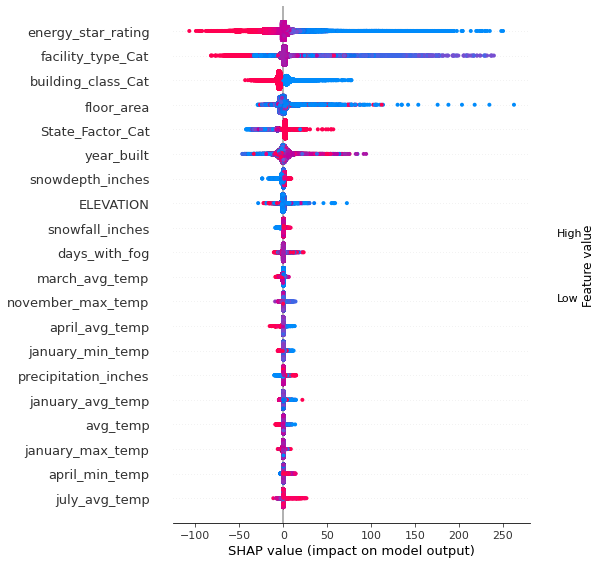

In [55]:
shap_values = shap.TreeExplainer(final_model_LE).shap_values(df_train_LE)
shap.summary_plot(shap_values, df_train_LE)

ℹ️ The features are ranked in descending order. 

**Top 3 most important features:**

1. `energy_star_rating`: energy star rating of the building is the most important feature -- this is not surprising!
2. `facility_type_Cat`: building usage type
3. `building_class_Cat`: whether it is a Commercial or Residential building

ℹ️ The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.

ℹ️ Color shows whether that variable is high (in red) or low (in blue) for that observation.

**Correlation:**

- A *low* `energy_star_rating` has a high and *positive* impact on the site energy usage intensity.
The *low* comes from the blue color, and *positive* is shown on the X-axis.

- `building_class_Cat` is a categorical feature so no correlation is inferred.


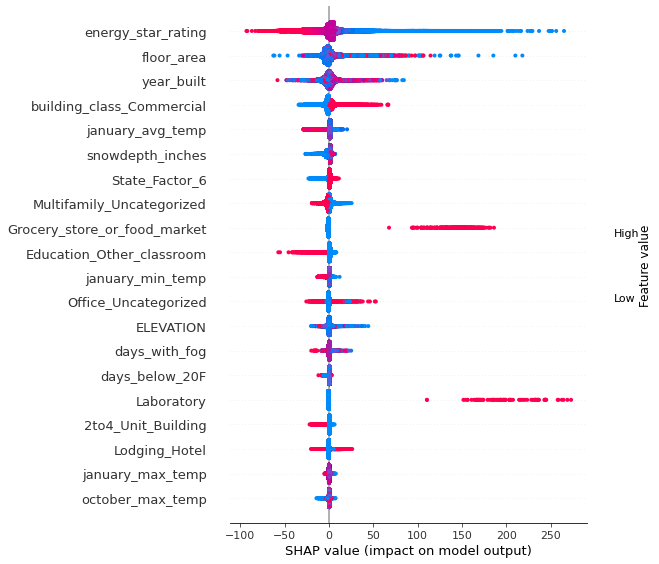

In [56]:
shap_values = shap.TreeExplainer(final_model_OHE).shap_values(df_train_OHE)
shap.summary_plot(shap_values, df_train_OHE)

ℹ️ Similar to the LE model, `energy_star_rating` is the number one most important feature. `floor_area` became more important, ranking number two.


# Submission

Using the best model we trained from the hyperparameter search, predict the target values of the test set.

### Data preprocessing on test dataframe
Basically just repeat what was done on train dataframe.

In [57]:
# Drop irrelevant columns
X_test = df_test.drop('Year_Factor', axis=1)
X_test = X_test.drop('id', axis=1)

# Handle null values
for col in ['year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']:
    X_test[col] = X_test[col].fillna(df_train[col].median())

# Encode categorial features
X_test['State_Factor_Cat'] = ordinalencoder.fit_transform(X_test['State_Factor'].to_numpy().reshape(-1, 1))
X_test['building_class_Cat'] = ordinalencoder.fit_transform(X_test['building_class'].to_numpy().reshape(-1, 1))
X_test['facility_type_Cat'] = ordinalencoder.fit_transform(X_test['facility_type'].to_numpy().reshape(-1, 1))

X_test = X_test.drop('State_Factor', axis=1)
X_test = X_test.drop('building_class', axis=1)
X_test = X_test.drop('facility_type', axis=1)

### Run predictions using best model

In [58]:
y_pred = final_model_LE.predict(X_test)

In [59]:
results = pd.DataFrame(df_test['id'])
results['site_eui'] = y_pred
results.head()

,id,site_eui
0,75757,252.488908
1,75758,219.125062
2,75759,258.487779
3,75760,247.904353
4,75761,284.657705


In [60]:
# write predictions to CSV
results.to_csv("submission.csv", header=True, index=False)

## This is my first public notebook on a Kaggle competition. Appreciate any comments or feedback! ##